## Credit Risk Assessment

#### The task is to predict the creditworthiness of individuals or businesses based on financial and demographic information

In [1]:
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

from sklearn.datasets import fetch_openml

# Neural Network
from keras.models import Sequential
from keras.layers import Dense, Dropout

import warnings
import pickle as pk
warnings.filterwarnings('ignore') 
sns.set(rc={'figure.figsize':(11,8)})

pd.options.display.float_format = '{:.2f}'.format

### 1. Import dataset 

In [2]:
df = pd.read_csv('german_credit_data.csv', usecols=range(1, 11))
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


### 2. EDA

### 2.1 Distributions and Visualizations

#### 2.1.1 Distribution of target variable

<Axes: xlabel='Risk', ylabel='count'>

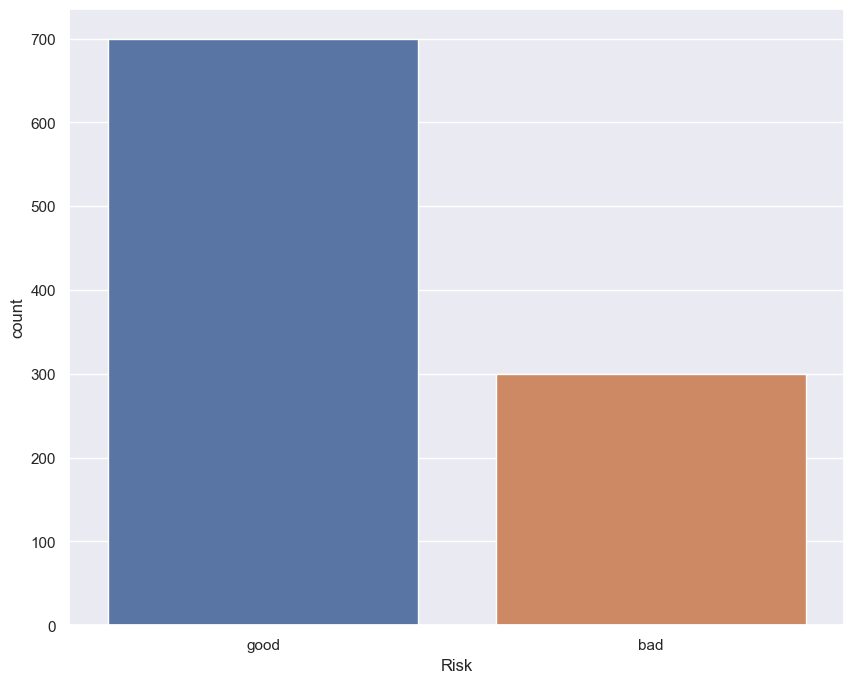

In [3]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.countplot(x='Risk', data=df)

In [4]:
num_cols = df._get_numeric_data().columns
cat_cols = df.columns.difference(num_cols)
cat_cols

Index(['Checking account', 'Housing', 'Purpose', 'Risk', 'Saving accounts',
       'Sex'],
      dtype='object')

#### 2.1.2 Distribution of numerical features

<Axes: xlabel='Credit amount', ylabel='Count'>

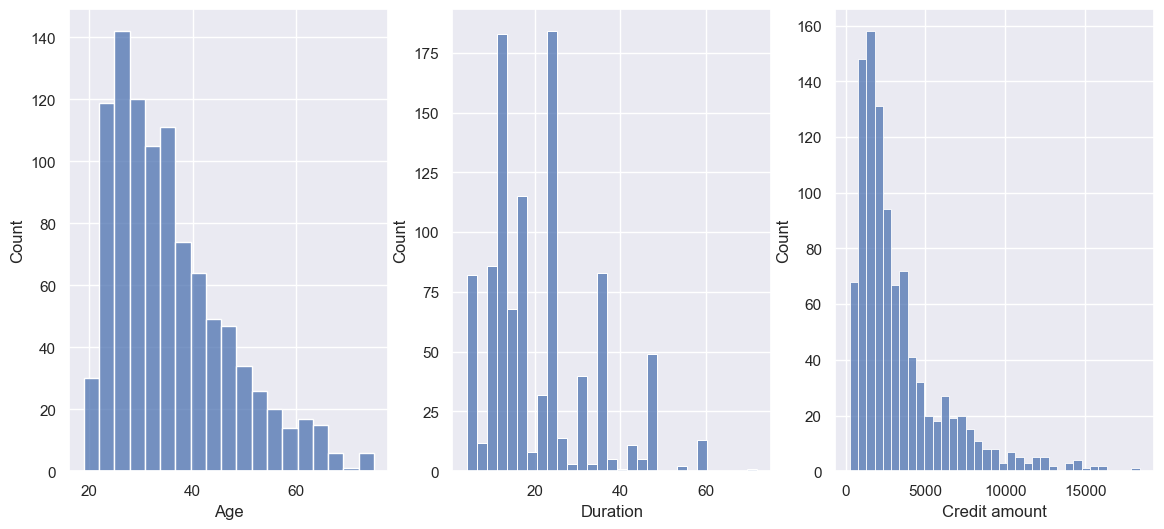

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(14, 6))

#Plot for checking the distribution of the Age feature
sns.histplot(df['Age'], ax = axes[0])

#Plot for checking the distribution of the Duration feature
sns.histplot(df['Duration'], ax = axes[1])

#Plot for checking the distribution of the Credit feature
sns.histplot(df['Credit amount'], ax = axes[2])

#### 2.1.3 Distribution of categorical features vs target

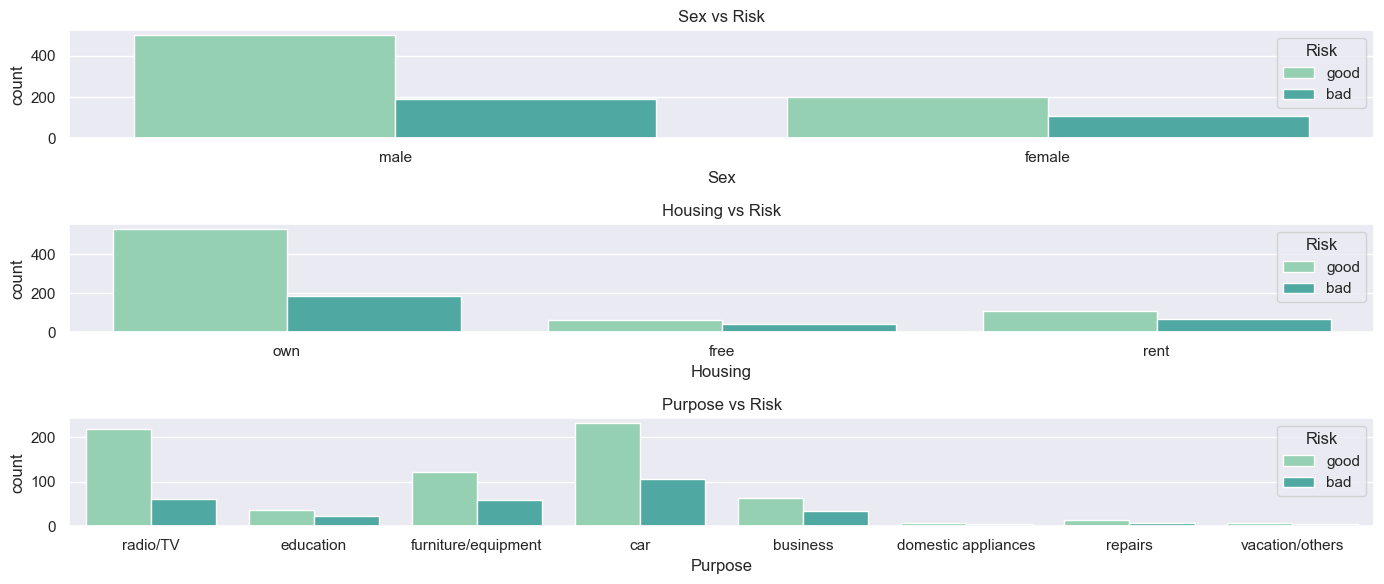

In [6]:
fig, axes = plt.subplots(3, 1, figsize=(14, 6))
sns.set_palette('mako_r')

#Plot for employment vs target
sns.countplot(x='Sex', hue='Risk', data=df, ax = axes[0])
axes[0].set_title('Sex vs Risk')

#Plot for housing vs target
sns.countplot(x='Housing', hue='Risk', data=df, ax = axes[1])
axes[1].set_title('Housing vs Risk')

#Plot for foreign worker vs target
sns.countplot(x='Purpose', hue='Risk', data=df, ax = axes[2])
axes[2].set_title('Purpose vs Risk')

plt.tight_layout()

Text(0.5, 1.0, 'Saving accounts vs Risk')

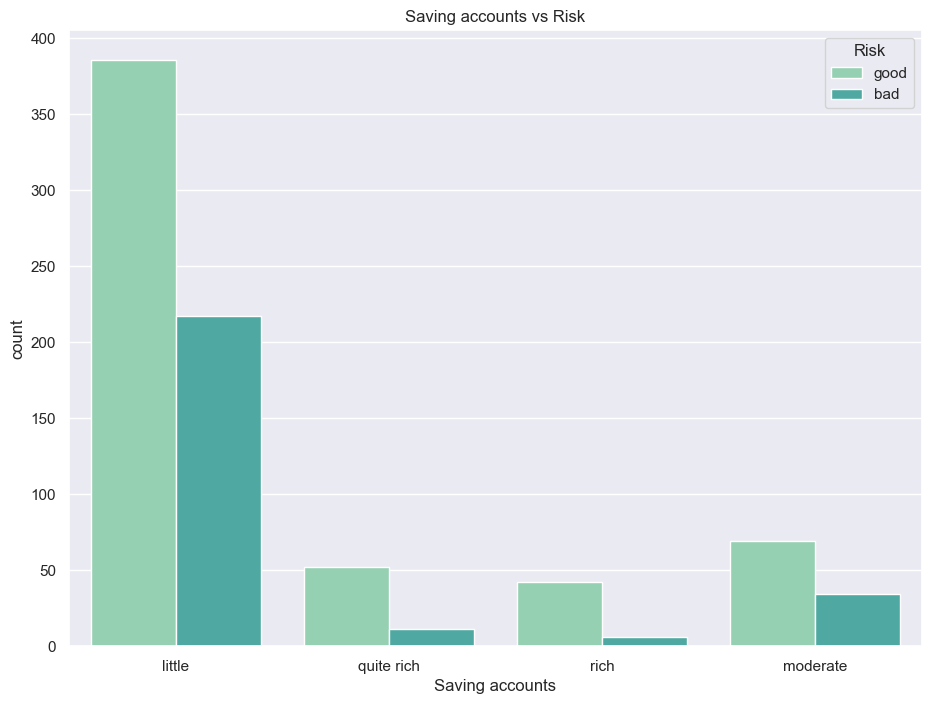

In [7]:
#Plot for Saving account vs Risk
sns.countplot(x='Saving accounts', hue='Risk', data=df)
plt.title('Saving accounts vs Risk')


Text(0.5, 1.0, 'Checking account vs Risk')

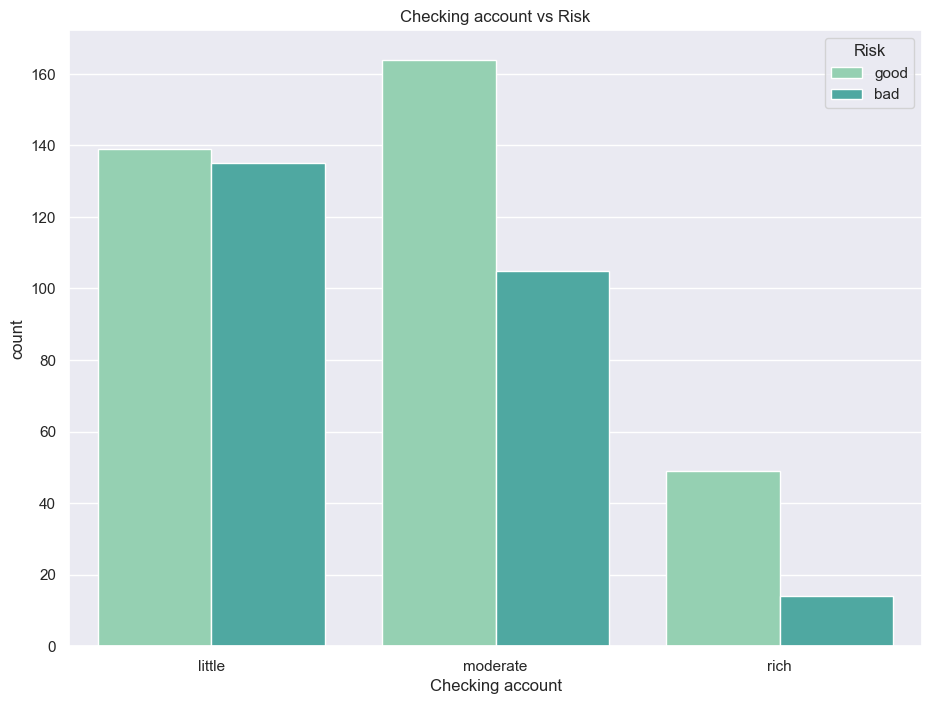

In [8]:
#Plot for Checking account vs Risk
sns.countplot(x='Checking account', hue='Risk', data=df)
plt.title('Checking account vs Risk')


### 2.2 Missing values

In [9]:
# check for missing values
missing_values = df.isna().sum()
missing_values[missing_values != 0]

Saving accounts     183
Checking account    394
dtype: int64

Since the missing values are categorical type, imputing using most-frequent values technique would result in not much loss of useful data 

In [10]:
freq_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    
def impute_by_frequent(col_name):
    df[col_name] = freq_imputer.fit_transform(df[col_name].values.reshape(-1,1)).ravel()

In [11]:
impute_cols = ['Saving accounts', 'Checking account']

for col in impute_cols:
    impute_by_frequent(col)

In [12]:
# check for missing values
missing_values = df.isna().sum()
missing_values[missing_values != 0]

Series([], dtype: int64)

In [13]:
df.describe()

,Age,Job,Credit amount,Duration
count,1000.00,1000.00,1000.00,1000.00
mean,35.55,1.90,3271.26,20.90
std,11.38,0.65,2822.74,12.06
min,19.00,0.00,250.00,4.00
25%,27.00,2.00,1365.50,12.00
50%,33.00,2.00,2319.50,18.00
75%,42.00,2.00,3972.25,24.00
max,75.00,3.00,18424.00,72.00


### 2.3 Standardize the numerical columns

In [14]:
num_cols

Index(['Age', 'Job', 'Credit amount', 'Duration'], dtype='object')

In [15]:
scaler = StandardScaler()

df_std = pd.DataFrame(scaler.fit_transform(df[num_cols]), columns=num_cols)
df_std.head()

,Age,Job,Credit amount,Duration
0,2.77,0.15,-0.75,-1.24
1,-1.19,0.15,0.95,2.25
2,1.18,-1.38,-0.42,-0.74
3,0.83,0.15,1.63,1.75
4,1.54,0.15,0.57,0.26


### 2.4 Encoding categorical feature values

In [16]:
cat_cols

Index(['Checking account', 'Housing', 'Purpose', 'Risk', 'Saving accounts',
       'Sex'],
      dtype='object')

In [17]:
df['Checking account'].value_counts()

Checking account
little      668
moderate    269
rich         63
Name: count, dtype: int64

Since the features 'Checking account' and 'Saving accounts' have a natural ordering in their values, we can use Ordinal encoding to convert them into numerical values. We use One-Hot encoding for other categorical columns

#### 2.4.1 Ordinal encoding

In [18]:
from sklearn.preprocessing import OrdinalEncoder
ord_encoder = OrdinalEncoder()
ord_encoded_cols = ['Checking account', 'Saving accounts']

df_ord_cat = pd.DataFrame(ord_encoder.fit_transform(df[ord_encoded_cols]), columns=ord_encoded_cols)
df_ord_cat.value_counts()

Checking account  Saving accounts
0.00              0.00               538
1.00              0.00               197
0.00              1.00                51
2.00              0.00                51
0.00              2.00                48
1.00              1.00                47
0.00              3.00                31
1.00              3.00                14
                  2.00                11
2.00              1.00                 5
                  2.00                 4
                  3.00                 3
Name: count, dtype: int64

#### 2.4.2 One-Hot encoding

In [19]:
df_hot_cat = pd.get_dummies(df[cat_cols.difference(ord_encoded_cols).drop('Risk')])
df_hot_cat.head()

,Housing_free,Housing_own,Housing_rent,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Sex_female,Sex_male
0,False,True,False,False,False,False,False,False,True,False,False,False,True
1,False,True,False,False,False,False,False,False,True,False,False,True,False
2,False,True,False,False,False,False,True,False,False,False,False,False,True
3,True,False,False,False,False,False,False,True,False,False,False,False,True
4,True,False,False,False,True,False,False,False,False,False,False,False,True


### 2.5 Combine standardized and encoded features

In [20]:
df_final = pd.concat([df_std, df_ord_cat, df_hot_cat], axis=1)
df_final.head()

,Age,Job,Credit amount,Duration,Checking account,Saving accounts,Housing_free,Housing_own,Housing_rent,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Sex_female,Sex_male
0,2.77,0.15,-0.75,-1.24,0.00,0.00,False,True,False,False,False,False,False,False,True,False,False,False,True
1,-1.19,0.15,0.95,2.25,1.00,0.00,False,True,False,False,False,False,False,False,True,False,False,True,False
2,1.18,-1.38,-0.42,-0.74,0.00,0.00,False,True,False,False,False,False,True,False,False,False,False,False,True
3,0.83,0.15,1.63,1.75,0.00,0.00,True,False,False,False,False,False,False,True,False,False,False,False,True
4,1.54,0.15,0.57,0.26,0.00,0.00,True,False,False,False,True,False,False,False,False,False,False,False,True


## 3. Identify feature and response space

In [21]:
y = df['Risk'].map({'good': 0, 'bad': 1})
y.head()

0    0
1    1
2    0
3    0
4    1
Name: Risk, dtype: int64

## 4. Split data into train and validation

In [22]:
X_train, X_val, y_train, y_val = train_test_split(df_final, y, test_size=0.2, random_state=1)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((800, 19), (200, 19), (800,), (200,))

## 5. Training Models

In [23]:
from sklearn.metrics import classification_report


def train_model(model):
    model.fit(X_train, y_train)
    
    # Get predicted values for validation set
    y_pred = model.predict(X_val)

    # Confusion matrix
    cm = pd.crosstab(y_pred, y_val, rownames =['y_pred'], colnames = ['y_val'] )
    print('Accuracy: ', model.score(X_val, y_val))
    print('CLassification report: \n', classification_report(y_pred, y_val))
    print('Confusion matrix: \n', cm)

### 5.1 Random Forest

#### 5.1.1 Baseline model

In [24]:
model = RandomForestClassifier()
train_model(model)

Accuracy:  0.695
CLassification report: 
               precision    recall  f1-score   support

           0       0.89      0.74      0.80       170
           1       0.24      0.47      0.31        30

    accuracy                           0.69       200
   macro avg       0.56      0.60      0.56       200
weighted avg       0.79      0.69      0.73       200

Confusion matrix: 
 y_val     0   1
y_pred         
0       125  45
1        16  14


The baseline model's accuracy is average and not great. Since it is worse to classify a bad customer as good, we need to focus on reducing the false positives.

#### 5.1.2 Tuning the model

In [25]:
param_grid = {
    'n_estimators': [100, 300, 500, 700, 1000, 1250],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)

In [26]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

#Best parameters
print(grid_search.best_params_)

#Best score
print(grid_search.best_score_)

{'max_depth': 90, 'max_features': 2, 'min_samples_leaf': 5, 'n_estimators': 100}
0.7125069227375556


In [27]:
model = RandomForestClassifier(**grid_search.best_params_)
train_model(model)

Accuracy:  0.715
CLassification report: 
               precision    recall  f1-score   support

           0       0.99      0.71      0.83       196
           1       0.05      0.75      0.10         4

    accuracy                           0.71       200
   macro avg       0.52      0.73      0.46       200
weighted avg       0.97      0.71      0.82       200

Confusion matrix: 
 y_val     0   1
y_pred         
0       140  56
1         1   3


Upon observing the performance of the tuned model, I find the tuned model to be overfitting on the data. Though the accuracies of both models are comparable, the confusion matrix of the tuned model shows that the model is trying to fit the data too well and hence the classification of true positive and false negatives are high which is not an ideal performance 

### 5.2 XGBoost

#### 5.1.1 Baseline model

In [28]:
xgb_model = xgb.XGBClassifier()
train_model(xgb_model)

Accuracy:  0.665
CLassification report: 
               precision    recall  f1-score   support

           0       0.79      0.75      0.77       150
           1       0.36      0.42      0.39        50

    accuracy                           0.67       200
   macro avg       0.58      0.58      0.58       200
weighted avg       0.68      0.67      0.67       200

Confusion matrix: 
 y_val     0   1
y_pred         
0       112  38
1        29  21


The XGBClassifier baseline model does not perform better than the RandomForest classifier model. The accuracy is lower, the classification of true positive is comparitively lesser and the classification of false positive has increased which is not an indicator of a good performance

#### 5.2.2 Tuned model

In [29]:
param_grid = {
    'n_estimators': [100, 300, 500, 700, 1000, 1250],
    'max_depth': [80, 90, 100, 110],
    'learning_rate': [0.01, 0.02, 0.05, 0.1],
    'min_child_weight': [0, 2, 5, 10],
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, n_jobs=-1)

In [30]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

#Best parameters
print(grid_search.best_params_)

#Best score
print(grid_search.best_score_)

{'learning_rate': 0.01, 'max_depth': 80, 'min_child_weight': 10, 'n_estimators': 500}
0.7012850478255563


In [31]:
xgb_model = xgb.XGBClassifier(**grid_search.best_params_)
train_model(xgb_model)

Accuracy:  0.7
CLassification report: 
               precision    recall  f1-score   support

           0       0.87      0.75      0.80       165
           1       0.29      0.49      0.36        35

    accuracy                           0.70       200
   macro avg       0.58      0.62      0.58       200
weighted avg       0.77      0.70      0.73       200

Confusion matrix: 
 y_val     0   1
y_pred         
0       123  42
1        18  17


The accuracy of the tuned model is better compared to that of the baseline model. The tuned model also classifies the true positives better. However the classification of false positive is still greater than the baseline Random Forest model. So the model's performance can be termed as average.

### 5.3 Neural Networks

#### 5.3.1 Baseline Model

In [32]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

In [33]:
X_train, X_val, y_train, y_val = train_test_split(df_final.to_numpy(), y.to_numpy(), test_size=0.2, random_state=1)
X_train

array([[-0.9275465787730462, 0.1469491804436178, -0.7047248690304435,
        ..., False, True, False],
       [1.2712647685933636, 0.1469491804436178, -0.312356056725048, ...,
        False, False, True],
       [-0.6636892170890771, 1.677669810064635, -0.12343773968911685,
        ..., False, True, False],
       ...,
       [0.919454953014738, -1.3837714491773996, 0.11439376262065766, ...,
        False, True, False],
       [-0.4877843092997643, 1.677669810064635, -0.5133254483936652, ...,
        False, False, True],
       [0.12788286796283044, 0.1469491804436178, -0.41514463447442895,
        ..., False, False, True]], dtype=object)

In [34]:
model = keras.Sequential([
    layers.Dense(units=128, activation='relu', input_shape=[X_train.shape[1]]),
    layers.Dense(units=1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [35]:
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

In [36]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=64,
    epochs=10
)

Epoch 1/10
13/13 [==============================] - 0s 7ms/step - loss: 0.6337 - accuracy: 0.6762 - val_loss: 0.5928 - val_accuracy: 0.7100
Epoch 2/10
13/13 [==============================] - 0s 2ms/step - loss: 0.5904 - accuracy: 0.7000 - val_loss: 0.5762 - val_accuracy: 0.7100
Epoch 3/10
13/13 [==============================] - 0s 2ms/step - loss: 0.5784 - accuracy: 0.7050 - val_loss: 0.5685 - val_accuracy: 0.7100
Epoch 4/10
13/13 [==============================] - 0s 2ms/step - loss: 0.5704 - accuracy: 0.7163 - val_loss: 0.5635 - val_accuracy: 0.7250
Epoch 5/10
13/13 [==============================] - 0s 2ms/step - loss: 0.5639 - accuracy: 0.7150 - val_loss: 0.5621 - val_accuracy: 0.7200
Epoch 6/10
13/13 [==============================] - 0s 2ms/step - loss: 0.5593 - accuracy: 0.7212 - val_loss: 0.5616 - val_accuracy: 0.7200
Epoch 7/10
13/13 [==============================] - 0s 2ms/step - loss: 0.5550 - accuracy: 0.7200 - val_loss: 0.5611 - val_accuracy: 0.7150
Epoch 8/10
13/13 [==

In [37]:
predictions = model.predict(X_val, verbose=1)
predictions = np.round(predictions).astype(int).reshape(1,-1)[0]
predictions

7/7 [==============================] - 0s 361us/step


array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [38]:
print(classification_report(y_val, predictions))

              precision    recall  f1-score   support

           0       0.72      0.95      0.82       141
           1       0.53      0.14      0.22        59

    accuracy                           0.71       200
   macro avg       0.63      0.54      0.52       200
weighted avg       0.67      0.71      0.64       200



#### 5.3.2 Adding another layer

In [43]:
model = keras.Sequential([
    layers.Dense(units=128, activation='relu', input_shape=[X_train.shape[1]]),
    layers.Dense(units=128, activation='relu'),
    layers.Dense(units=128, activation='relu'),
    layers.Dense(units=1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [44]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=64,
    epochs=10
)

Epoch 1/10
13/13 [==============================] - 0s 6ms/step - loss: 0.6364 - accuracy: 0.6425 - val_loss: 0.5935 - val_accuracy: 0.7050
Epoch 2/10
13/13 [==============================] - 0s 2ms/step - loss: 0.5783 - accuracy: 0.7088 - val_loss: 0.5736 - val_accuracy: 0.6900
Epoch 3/10
13/13 [==============================] - 0s 2ms/step - loss: 0.5618 - accuracy: 0.7125 - val_loss: 0.5728 - val_accuracy: 0.7050
Epoch 4/10
13/13 [==============================] - 0s 2ms/step - loss: 0.5488 - accuracy: 0.7250 - val_loss: 0.5717 - val_accuracy: 0.7000
Epoch 5/10
13/13 [==============================] - 0s 2ms/step - loss: 0.5367 - accuracy: 0.7312 - val_loss: 0.5723 - val_accuracy: 0.6850
Epoch 6/10
13/13 [==============================] - 0s 2ms/step - loss: 0.5221 - accuracy: 0.7437 - val_loss: 0.5774 - val_accuracy: 0.6900
Epoch 7/10
13/13 [==============================] - 0s 2ms/step - loss: 0.5097 - accuracy: 0.7538 - val_loss: 0.5826 - val_accuracy: 0.6950
Epoch 8/10
13/13 [==

In [45]:
predictions = model.predict(X_val, verbose=1)
predictions = np.round(predictions).astype(int).reshape(1,-1)[0]
predictions

7/7 [==============================] - 0s 482us/step


array([0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0])

In [46]:
print(classification_report(y_val, predictions))

              precision    recall  f1-score   support

           0       0.74      0.84      0.79       141
           1       0.44      0.31      0.36        59

    accuracy                           0.68       200
   macro avg       0.59      0.57      0.57       200
weighted avg       0.65      0.68      0.66       200



### Comparing results from three models

Out of the three models - RandomForest, XGBoost and NN, the XGBoost classifier (hypertuned model) performed the best with accuracy : 0.7 and weighted averages of precision, recall and F1 score as :  0.77      0.70      0.73 respectively. 